entries probhabs =  4
free data
max, min for 0.1 47.63614285714287 25.256457142857247
max, min for 0.2 95.27328571428573 60.03048571428576
max, min for 0.3 142.9104285714286 94.80451428571432
entries probhabs =  4
tasked data
max, min for 0.1 -27.36285714285713 -49.742542857142745
max, min for 0.2 20.27428571428574 -14.96851428571425
max, min for 0.3 67.91142857142862 19.80551428571432


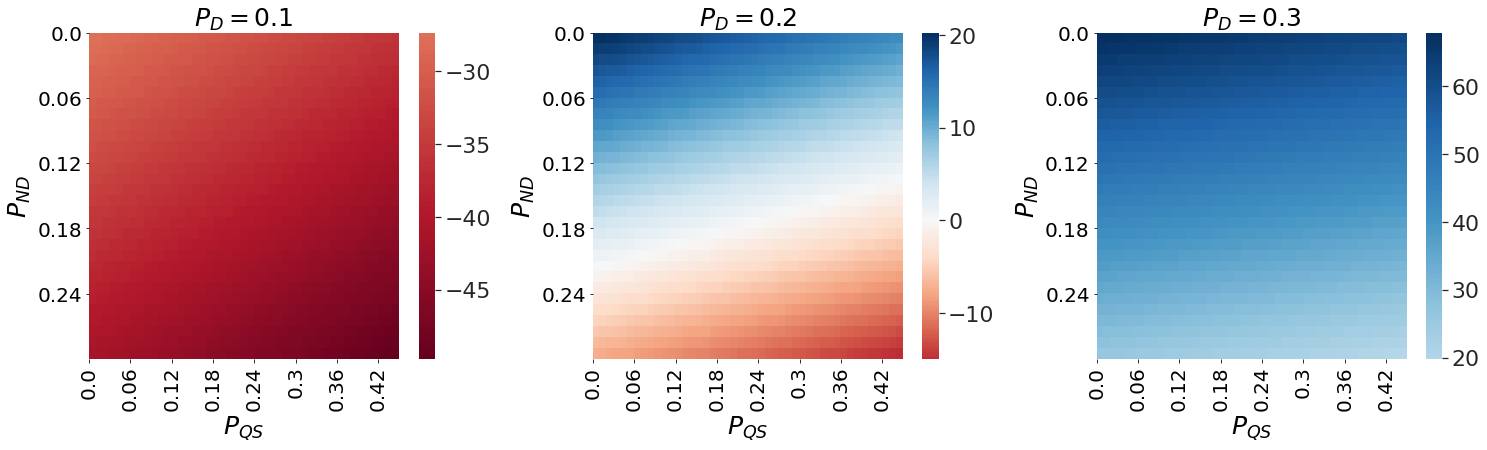

entries probhabs =  4
analytics
max, min for 0.1 11.21714285714287 -11.162542857142748
max, min for 0.2 58.85428571428574 23.611485714285752
max, min for 0.3 106.49142857142861 58.385514285714336


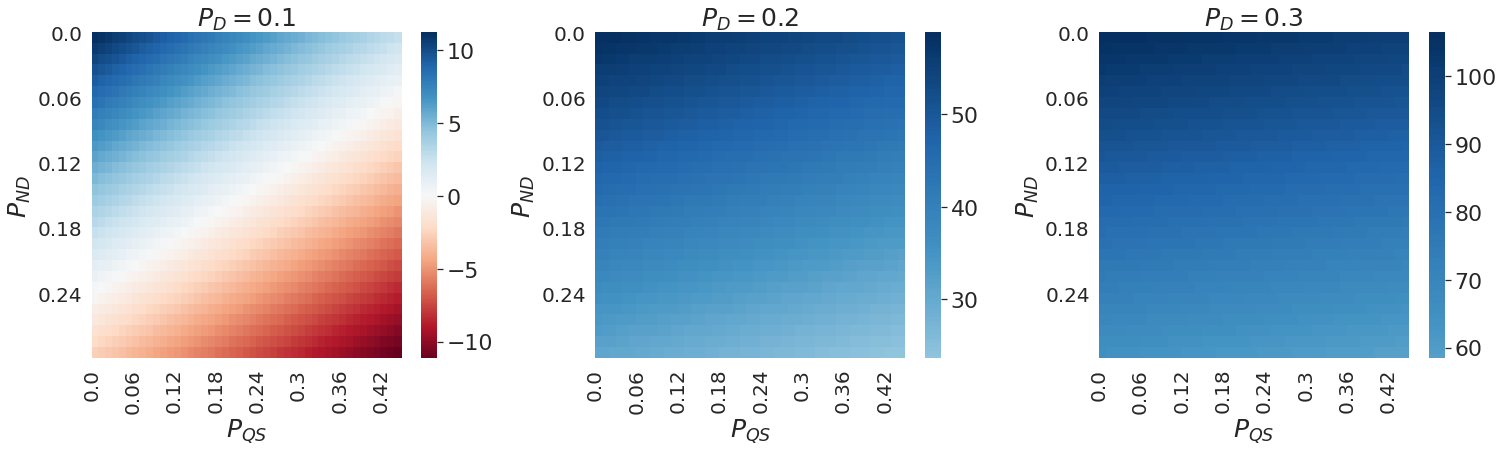

entries probhabs =  4


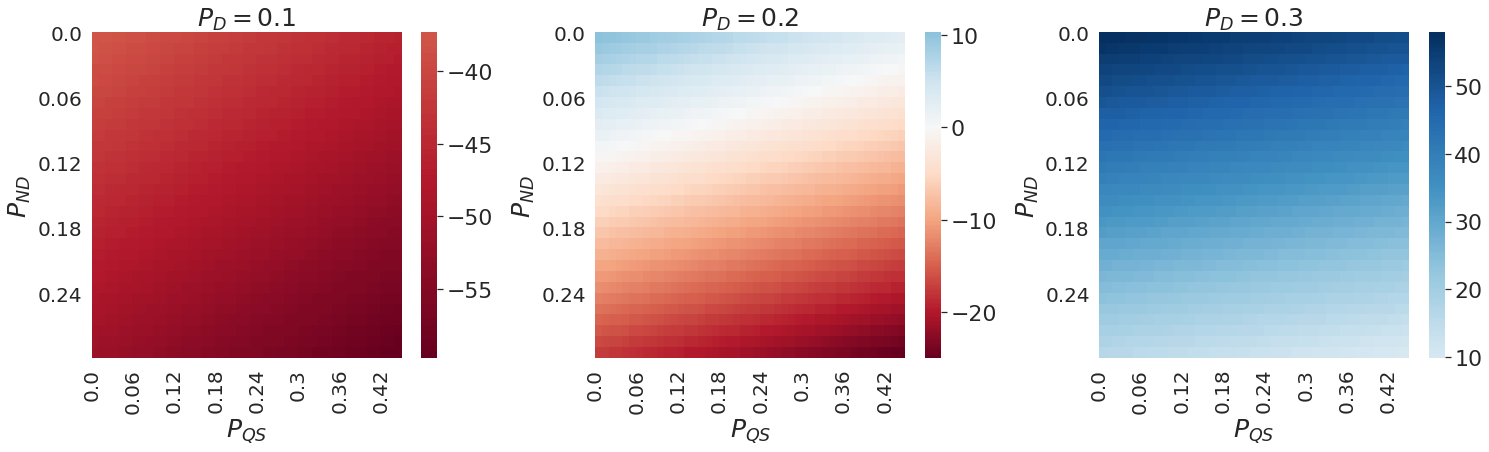

In [ ]:
##############################################################################
#Decision case for monitoring HABS
# 
#Original Author: Afreen Siddiqi
#Translated into python by Sheila Baber
##############################################################################

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

###############################################################################
#Sensitivity to cost variation
###############################################################################

'''

Here we generate the data, this time with changes to cost

Note that this is really dependent on the application area

'''
#[dollars/month converted to weekly costs], assuming 25k subscription and $1000 per analyzed image and 50 images 
#assuming six months of image purchase <-- Original

#CASES OF COST

C_rem_free = 1 # [cost/yr] If using freely available data from NOAA, no further processing (but higher error rate) 
C_rem_tasked = 50000+500*50 #[cost/yr] If using custom obtained imagery (taking roughly $2/km, but 250 km minimum, weekly-- if one were tasking Planet satellites) + cost of GIS person
C_rem_analytics = 535*12+30000 #[cost/yr] -- based on Catalyst numbers, the bundle that has analysis ready tools and atmospheric corrections, and someone who is paid less

C_fieldTesting = 200; #cost of field sample collection and lab testing http://www.communityscience.org/certified-water-testing/drinking-water-tests-fees/

C_treat_mild = 12; #[$/person]
C_treat_moderate = 265; #[$/person]
C_treat_severe = 10000; #[$/person]

Park_ticket = 5; #[$/person], cost of entry ticket to lake park (estimate)

V = 10000; #[persons visiting / week]

Exposure_days = 3; #[days], number of days visitors are exposed prior to any closure
nVisitorsExposed = V/7 * Exposure_days;
TicketRevenueLoss = V/7*Park_ticket*Exposure_days; #[$/day]

frac_mild = 0.05
frac_moderate = 0.04
frac_severe = 0.01; # approximations based on [1]

#public health costs, estimated as sum of treatment costs for mild,moderate, and severe cases 
TreatmentCost = nVisitorsExposed*(frac_mild*C_treat_mild + frac_moderate*C_treat_moderate + frac_severe*C_treat_severe); #[$]
##############################################################################

diff_list = []
rem_sen_list = []

##############################################################################
# DATA GENERATION
##############################################################################


def HABS_analysis(C_RemSens):
  '''

  Produces the datasets to be used in graphing according to cost
  C_RemSens is a variable in this case! 

  '''
  C_fieldTesting = 200; #cost of field sample collection and lab testing http://www.communityscience.org/certified-water-testing/drinking-water-tests-fees/ 


  C_treat_mild = 12; #[$/person]
  C_treat_moderate = 265; #[$/person]
  C_treat_severe = 10000; #[$/person]

  Park_ticket = 5; #[$/person], cost of entry ticket to lake park (estimate)

  V = 10000; #[persons visiting / week]

  Exposure_days = 3; #[days], number of days visitors are exposed prior to any closure
  nVisitorsExposed = V/7 * Exposure_days;
  TicketRevenueLoss = V/7*Park_ticket*Exposure_days; #[$/day]

  frac_mild = 0.05
  frac_moderate = 0.04
  frac_severe = 0.01; # approximations based on [1]

  #public health costs, estimated as sum of treatment costs for mild,moderate, and severe cases 
  TreatmentCost = nVisitorsExposed*(frac_mild*C_treat_mild + frac_moderate*C_treat_moderate + frac_severe*C_treat_severe); #[$]

  ##############################################################################
  ## outcomes in decision tree
  O1 = -1*(C_RemSens+C_fieldTesting);
  O2 = -1*(TreatmentCost+ C_fieldTesting+C_RemSens); 
  O3 = -1*(C_fieldTesting+C_RemSens);
  O4 = -1*(C_fieldTesting+C_RemSens+TicketRevenueLoss);
  O5 = -1*(C_RemSens);
  O6 = -1*(C_RemSens+TreatmentCost);
  O7 = -1*(TreatmentCost);
  O8 = 0;

  ##############################################################################
  ProbHABs = np.arange(0.1, 0.4, 0.1)
  print("entries probhabs = ", len(ProbHABs))

  diff_list = []
  rem_sen_list = []

  for k in range(0, len(ProbHABs)):
      #figure(1)
      #fig1, axs1 = plt.subplots(2, 2)
      #axs[k].plot()
      #plt.subplot(2,2,k)
      #Pd = 0.35; #probability of dangerous condition, P (D),  (harmful algal bloom occuring) 
      Pd = ProbHABs[k];
      Ps = 1-Pd; #probabiliy of safe condition, P (S) 
      Pnd = 0.1; # P(N | D) = 0.1, i.e probability of negative rem sens result for a HAB while dangerous condition exists in reality, false negative
      Pqs = 0.2; # P(Q | S) = 0.1, i.e probability of positive rem sens result for a HAB while safe condition exists in reality, false positive

      #error_vec=0:0.01:0.45;
      error_vec= np.arange(0, 0.45, 0.01)
      #error_vec_ND=0:0.01:0.3;
      error_vec_ND= np.arange(0, 0.3, 0.01);
      
      
      DecisionDiff = np.zeros((len(error_vec_ND),len(error_vec))); #difference between use of remote sensing versus no use of remote sensing
      remSens_ROI = np.zeros((len(error_vec_ND),len(error_vec))); #return on investment for remote sensing

      for i in range(0, len(error_vec_ND)):
          for j in range(0, len(error_vec)):
              Pnd = error_vec[i];
              Pqs = error_vec[j];
          # equations for probabilities
              P1 = ((1-Pnd)*Pd) + (Pqs*Ps);
              P2 = 1- P1;
              P3 = Pqs*Ps/P1;
              P4 = 1- P3;
              P5 = P3;
              P6 = P4;
              P7 = ((1-Pqs)*(1-Pd))/(1-P1);
              P8 = 1-P7;
          # value at nodes of decision tree
              C5 = P4*O2+P3*O1;
              C4 = P6*O3+P5*O4;

              D2 = max(C5, C4);

              C2 = P2*(P8*O6 + P7*O5) + P1*D2;
              C1 = Ps*O8 + Pd*O7;
    
              DecisionDiff[i,j] = (C2-C1)/1000; #[thousand $], if positive, then remote sensing is better, if negative, then no remote sensing is cheaper
              remSens_ROI[i,j] = 100*((C2-C1)-C_RemSens)/ C_RemSens; #return on investment based on cost of remote sensing

      diff_list.append(np.array(DecisionDiff))
      rem_sen_list.append(np.array(remSens_ROI))

  diff_array = np.array(diff_list)
  rem_sen_array = np.array(rem_sen_list)
        
  return diff_array, rem_sen_array

##############################################################################
# DATA VISUALIZATION FUNCTION
##############################################################################

def plot(data):
  '''
  data can either be diff_array or roi_array (you'll need to index before)
  '''

  fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6)) #first heatmap

  #fig.suptitle('Remote Sensing ROI', fontsize=30)

  #error_vec=0:0.01:0.45;
  error_vec= np.arange(0, 0.45, 0.01)
  #error_vec_ND=0:0.01:0.3;
  error_vec_ND= np.arange(0, 0.3, 0.01);
      

  colormap = 'RdBu'
  plt.subplots_adjust(wspace= 0.3)
  textsize = 25
  smalltext = 20
  titlesize = 30

  sns.set(font_scale=2)

  g1 = sns.heatmap(np.array(data[0]), cmap = colormap, ax = ax1, center=0.00)
  g2 = sns.heatmap(np.array(data[1]), cmap = colormap, ax = ax2,  center=0.00)
  g3 = sns.heatmap(np.array(data[2]), cmap = colormap, ax = ax3,  center=0.00)

  ax1.get_shared_y_axes().join(ax2,ax3)

  for i, ax in enumerate([g1,g2,g3]):
      labels = [0.1, 0.2, 0.3, 0.4]

      ax.set_xticks(np.arange(0, len(error_vec), 6))
      ax.set_xticklabels(error_vec[::6], fontsize = smalltext, rotation = 90)

      ax.set_yticks(np.arange(0, len(error_vec_ND), 6))
      ax.set_yticklabels(error_vec_ND[::6], rotation=0, fontsize = smalltext)

      #set the labels

      ax.set_xlabel('$P_{QS}$', fontsize = textsize)
      ax.set_ylabel('$P_{ND}$', fontsize = textsize)
      ax.set_title('$P_D = {}$'.format(labels[i]) , fontsize = textsize)

  plt.show()

##############################################################################
# CASE 1: FREE REM
##############################################################################

rem_free = HABS_analysis(C_rem_free)

print("free data")
print("max, min for 0.1", np.amax(rem_free[0][0]), np.amin(rem_free[0][0]))
print("max, min for 0.2", np.amax(rem_free[0][1]), np.amin(rem_free[0][1]))
print("max, min for 0.3", np.amax(rem_free[0][2]), np.amin(rem_free[0][2]))

#plot(rem_free[0])
#plot(rem_free[1])
##############################################################################
# CASE 2: TAKSED REM
##############################################################################

rem_tasked = HABS_analysis(C_rem_tasked)

print("tasked data")
print("max, min for 0.1", np.amax(rem_tasked[0][0]), np.amin(rem_tasked[0][0]))
print("max, min for 0.2", np.amax(rem_tasked[0][1]), np.amin(rem_tasked[0][1]))
print("max, min for 0.3", np.amax(rem_tasked[0][2]), np.amin((rem_tasked[0][2])))
plot(rem_tasked[0])
#plot(rem_tasked[1])
##############################################################################
# CASE 3: ANALYTICS REM
##############################################################################

rem_analytics = HABS_analysis(C_rem_analytics)
print("analytics")
print("max, min for 0.1", np.amax(rem_analytics[0][0]), np.amin(rem_analytics[0][0]))
print("max, min for 0.2", np.amax(rem_analytics[0][1]), np.amin(rem_analytics[0][1]))
print("max, min for 0.3", np.amax(rem_analytics[0][2]), np.amin(rem_analytics[0][2]))

plot(rem_analytics[0])
#plot(rem_analytics[1])


##############################################################################
# CASE 4: ORIGINAL ASSUMPTIONS
##############################################################################

C_RemSens = (25000+1200*50);

rem_original = HABS_analysis(C_RemSens)

plot(rem_original[0])
#plot(rem_original[1])





In [ ]:
##############################################################################
#Decision case for monitoring HABS
# 
#Original Author: Afreen Siddiqi
#Translated into python by Sheila Baber
##############################################################################

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

##############################################################################
#Generating the data
##############################################################################

C_RemSens = (25000+1200*50); #[dollars/month converted to weekly costs], assuming 25k subscription and $1000 per analyzed image and 50 images 
#assuming six months of image purchase

C_fieldTesting = 200; #cost of field sample collection and lab testing http://www.communityscience.org/certified-water-testing/drinking-water-tests-fees/ 


C_treat_mild = 12; #[$/person]
C_treat_moderate = 265; #[$/person]
C_treat_severe = 10000; #[$/person]

Park_ticket = 5; #[$/person], cost of entry ticket to lake park (estimate)

V = 10000; #[persons visiting / week]

Exposure_days = 3; #[days], number of days visitors are exposed prior to any closure
nVisitorsExposed = V/7 * Exposure_days;
TicketRevenueLoss = V/7*Park_ticket*Exposure_days; #[$/day]

frac_mild = 0.05
frac_moderate = 0.04
frac_severe = 0.01; # approximations based on [1]

#public health costs, estimated as sum of treatment costs for mild,moderate, and severe cases 
TreatmentCost = nVisitorsExposed*(frac_mild*C_treat_mild + frac_moderate*C_treat_moderate + frac_severe*C_treat_severe); #[$]

##############################################################################
## outcomes in decision tree
O1 = -1*(C_RemSens+C_fieldTesting);
O2 = -1*(TreatmentCost+ C_fieldTesting+C_RemSens); 
O3 = -1*(C_fieldTesting+C_RemSens);
O4 = -1*(C_fieldTesting+C_RemSens+TicketRevenueLoss);
O5 = -1*(C_RemSens);
O6 = -1*(C_RemSens+TreatmentCost);
O7 = -1*(TreatmentCost);
O8 = 0;

##############################################################################
ProbHABs = np.arange(0.1, 0.4, 0.1)

diff_list = []
rem_sen_list = []

for k in range(0, len(ProbHABs)):
    #figure(1)
    #fig1, axs1 = plt.subplots(2, 2)
    #axs[k].plot()
    #plt.subplot(2,2,k)
    #Pd = 0.35; #probability of dangerous condition, P (D),  (harmful algal bloom occuring) 
    Pd = ProbHABs[k];
    Ps = 1-Pd; #probabiliy of safe condition, P (S) 
    Pnd = 0.1; # P(N | D) = 0.1, i.e probability of negative rem sens result for a HAB while dangerous condition exists in reality, false negative
    Pqs = 0.2; # P(Q | S) = 0.1, i.e probability of positive rem sens result for a HAB while safe condition exists in reality, false positive

    #error_vec=0:0.01:0.45;
    error_vec= np.arange(0, 0.45, 0.01)
    #error_vec_ND=0:0.01:0.3;
    error_vec_ND= np.arange(0, 0.3, 0.01);
    
    
    DecisionDiff = np.zeros((len(error_vec_ND),len(error_vec))); #difference between use of remote sensing versus no use of remote sensing
    remSens_ROI = np.zeros((len(error_vec_ND),len(error_vec))); #return on investment for remote sensing

    for i in range(0, len(error_vec_ND)):
        for j in range(0, len(error_vec)):
            Pnd = error_vec[i];
            Pqs = error_vec[j];
        # equations for probabilities
            P1 = ((1-Pnd)*Pd) + (Pqs*Ps);
            P2 = 1- P1;
            P3 = Pqs*Ps/P1;
            P4 = 1- P3;
            P5 = P3;
            P6 = P4;
            P7 = ((1-Pqs)*(1-Pd))/(1-P1);
            P8 = 1-P7;
        # value at nodes of decision tree
            C5 = P4*O2+P3*O1;
            C4 = P6*O3+P5*O4;

            D2 = max(C5, C4);

            C2 = P2*(P8*O6 + P7*O5) + P1*D2;
            C1 = Ps*O8 + Pd*O7;
  
            DecisionDiff[i,j] = (C2-C1)/1000; #[thousand $], if positive, then remote sensing is better, if negative, then no remote sensing is cheaper
            remSens_ROI[i,j] = 100*((C2-C1)-C_RemSens)/ C_RemSens; #return on investment based on cost of remote sensing

    diff_list.append(np.array(DecisionDiff))
    rem_sen_list.append(np.array(remSens_ROI))

diff_array = np.array(diff_list)
rem_sen_array = np.array(rem_sen_list)
      



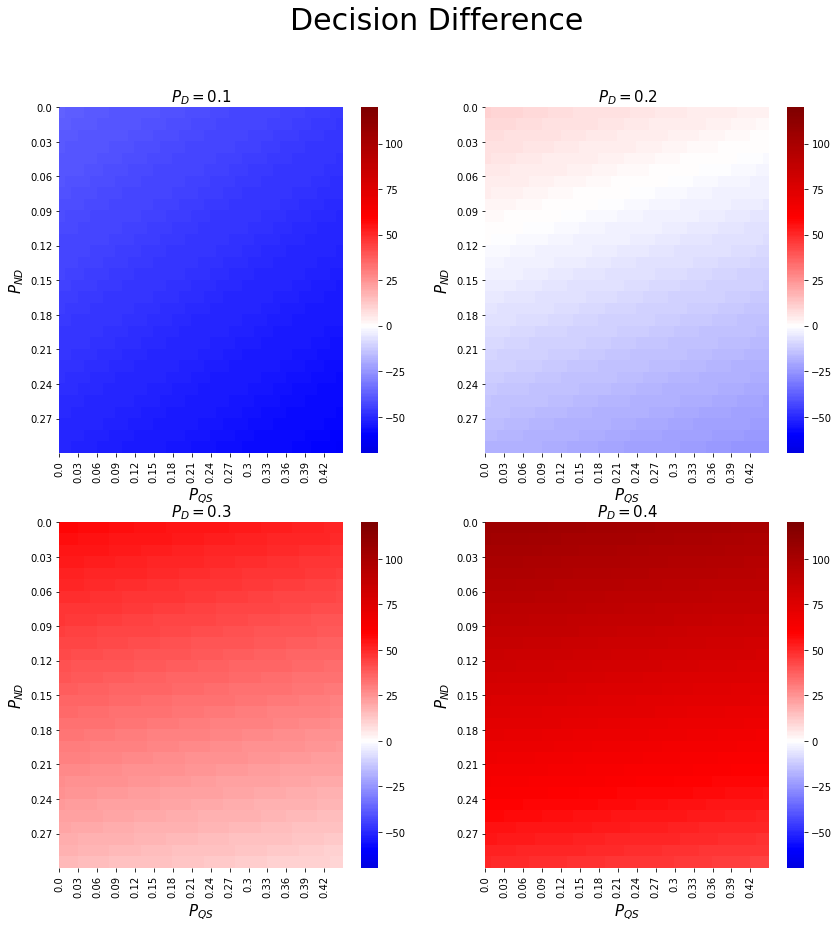

what is this [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29]


In [ ]:
##############################################################################
#Plot with respect to Diff
##############################################################################

#heatmap(diff_array[0], 'test', 'bwr')

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(14, 14)) #first heatmap
#fig.suptitle('Decision Difference', fontsize=30)


colormap = 'seismic'

data = diff_array[0]

textsize = 15
titlesize = 20
_min = -70.0
_max = 120
g1 = sns.heatmap(np.array(diff_array[0]), cmap = colormap, ax = ax1, vmin= _min,vmax= _max, center = 0)
g2 = sns.heatmap(np.array(diff_array[1]), cmap = colormap, ax = ax2, vmin= _min,vmax= _max, center = 0)
g3 = sns.heatmap(np.array(diff_array[2]), cmap = colormap, ax = ax3, vmin= _min,vmax= _max, center = 0)
g4 = sns.heatmap(np.array(diff_array[3]), cmap = colormap, ax = ax4, vmin= _min,vmax= _max, center = 0)

ax1.get_shared_y_axes().join(ax2,ax3, ax4)


for i, ax in enumerate([g1,g2,g3, g4]):
    labels = [0.1, 0.2, 0.3, 0.4]
    # tl = ax.get_xticklabels()
    # ax.set_xticklabels(tl, rotation=90)
    # tly = ax.get_yticklabels()
    # ax.set_yticklabels(tly, rotation=0)
    ax.set_xticks(np.arange(0, len(error_vec), 3))
    ax.set_xticklabels(error_vec[::3])

    ax.set_yticks(np.arange(0, len(error_vec_ND), 3))
    ax.set_yticklabels(error_vec_ND[::3])

    #set the labels

    ax.set_xlabel('$P_{QS}$', fontsize = textsize)
    ax.set_ylabel('$P_{ND}$', fontsize = textsize)
    ax.set_title('$P_D = {}$'.format(labels[i]) , fontsize = textsize)

plt.show()


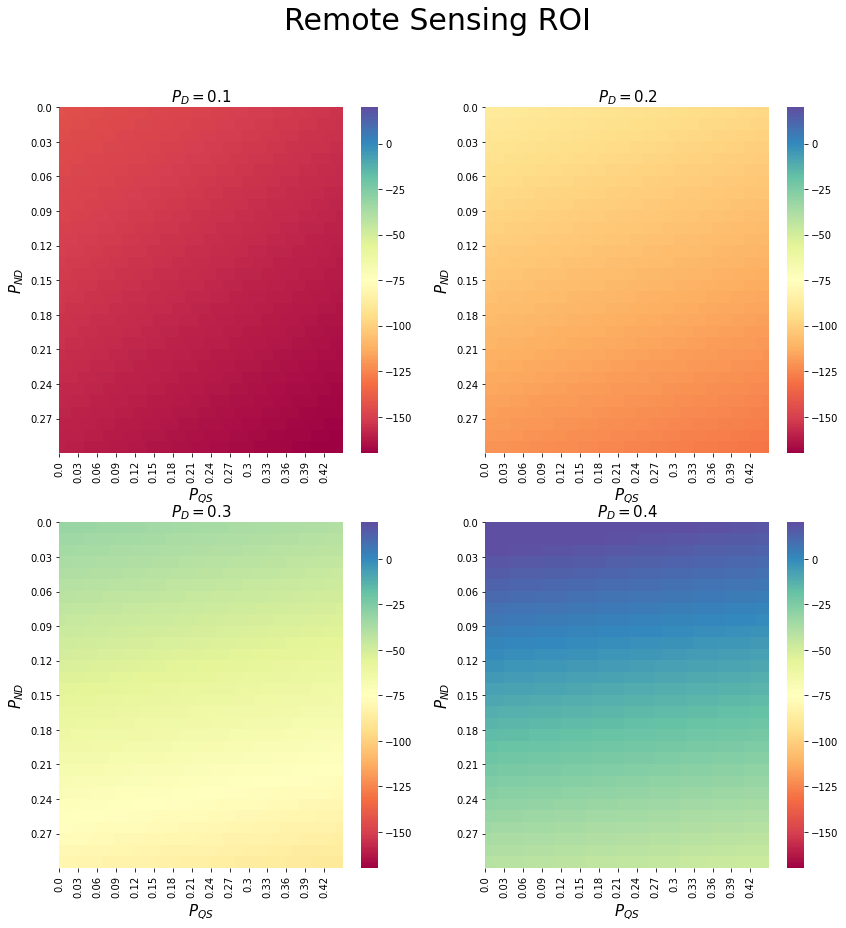

In [ ]:

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(14, 14)) #first heatmap

#fig.suptitle('Remote Sensing ROI', fontsize=30)

colormap = 'Spectral'

textsize = 15
titlesize = 20
_min = -170
_max = 20
g1 = sns.heatmap(np.array(rem_sen_array[0]), cmap = colormap, ax = ax1, vmin= _min,vmax= _max)
g2 = sns.heatmap(np.array(rem_sen_array[1]), cmap = colormap, ax = ax2, vmin= _min,vmax= _max)
g3 = sns.heatmap(np.array(rem_sen_array[2]), cmap = colormap, ax = ax3, vmin= _min,vmax= _max)
g4 = sns.heatmap(np.array(rem_sen_array[3]), cmap = colormap, ax = ax4, vmin= _min,vmax= _max)

ax1.get_shared_y_axes().join(ax2,ax3, ax4)



for i, ax in enumerate([g1,g2,g3, g4]):
    labels = [0.1, 0.2, 0.3, 0.4]
    # tl = ax.get_xticklabels()
    # ax.set_xticklabels(tl, rotation=90)
    # tly = ax.get_yticklabels()
    # ax.set_yticklabels(tly, rotation=0)
    ax.set_xticks(np.arange(0, len(error_vec), 3))
    ax.set_xticklabels(error_vec[::3])

    ax.set_yticks(np.arange(0, len(error_vec_ND), 3))
    ax.set_yticklabels(error_vec_ND[::3])

    #set the labels

    ax.set_xlabel('$P_{QS}$', fontsize = textsize)
    ax.set_ylabel('$P_{ND}$', fontsize = textsize)
    ax.set_title('$P_D = {}$'.format(labels[i]) , fontsize = textsize)

plt.show()


